In [1]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'mps'

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
image_path.mkdir(exist_ok=True, parents=True)

# Download the data
data_url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
r = requests.get(data_url)
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    f.write(r.content)

# Unzip the data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    zip_ref.extractall(image_path)

# Remove the zip file
(data_path / "pizza_steak_sushi.zip").unlink()

In [3]:
import os


def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'."
        )

In [4]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image format: JPEG
Image size: (512, 512)


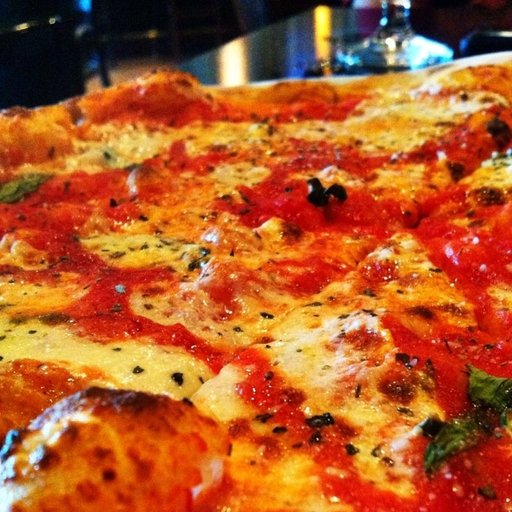

In [6]:
import random
from PIL import Image

random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from the image path name (name of the directory the image is in)
img_class = random_image_path.parent.name

# 4. Open the image using PIL and display it
img = Image.open(fp=random_image_path)

# 5. Print metadata about the image
print(f"Image path: {random_image_path}")
print(f"Image class: {img_class}")
print(f"Image format: {img.format}")
print(f"Image size: {img.size}")
img

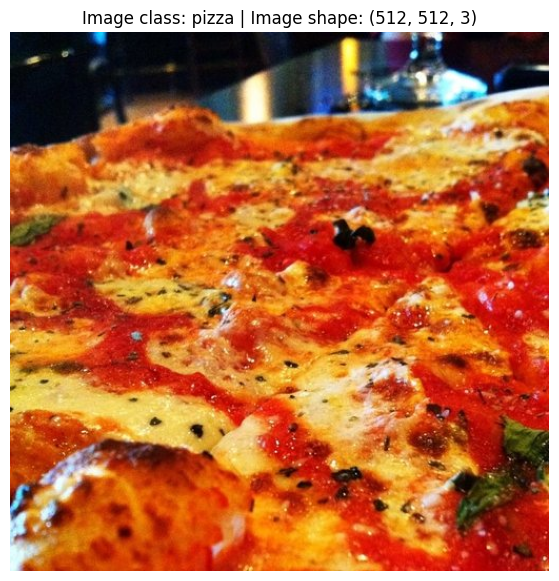

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Turn an image into a NumPy array
img_array = np.array(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_array)
plt.axis(False)
plt.title(f"Image class: {img_class} | Image shape: {img_array.shape}")
plt.show()

### Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (numerical representation of our images)
2. Turn it into a `torch.utils.data.Dataset` object and subsequently a `torch.utils.data.DataLoader` object, we call these `Dataset` and `DataLoader` respectively.

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [9]:
data_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),  # resize the images to 64x64
        transforms.RandomHorizontalFlip(
            p=0.5
        ),  # 30% of the images will be flipped horizontally
        transforms.ToTensor(),  # convert the image to a pytorch tensor
    ]
)

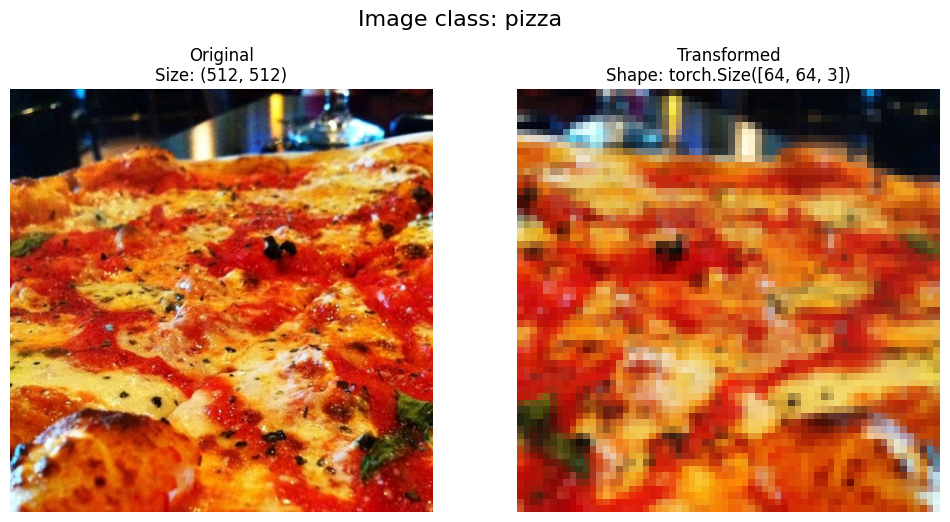

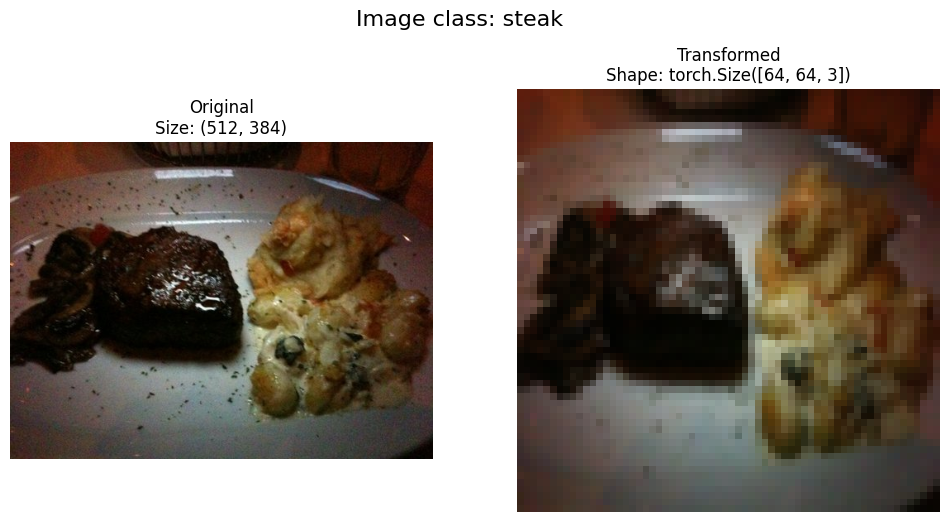

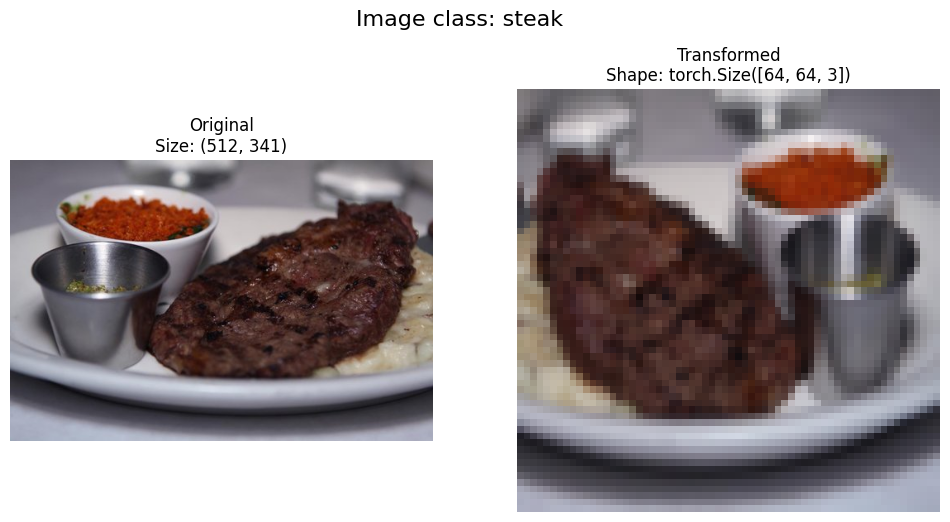

In [10]:
def plot_transformed_images(img_paths: list, transform, n=3, seed=None):
    """
    Selects random images from a list of image paths and displays them with a given transform.
    """

    if seed:
        random.seed(seed)
    random_img_paths = random.sample(img_paths, k=n)
    for img_path in random_img_paths:
        with Image.open(img_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
            ax[0].imshow(f)
            ax[0].set_title("Original\nSize: {}".format(f.size))
            ax[0].axis(False)

            # Apply the transform and show the image
            transformed_img = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_img)
            ax[1].set_title("Transformed\nShape: {}".format(transformed_img.shape))
            ax[1].axis(False)

            fig.suptitle(f"Image class: {img_path.parent.name}", fontsize=16)


plot_transformed_images(img_paths=image_path_list, transform=data_transform, seed=42)

### Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`.

In [11]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,  # Transform for the data
    target_transform=None,  # Transform for the labels (target)
)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
len(train_data), len(test_data)

(225, 75)

In [15]:
# Index on the train_data Dataset to get a single image and its label
img, label = train_data[0]
print(
    f"Image shape: {img.shape}\nImage data type: {img.dtype}\nImage label: {label}\nLabel data type: {type(label)}"
)

Image shape: torch.Size([3, 64, 64])
Image data type: torch.float32
Image label: 0
Label data type: <class 'int'>


Original image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Permuted image shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


(-0.5, 63.5, 63.5, -0.5)

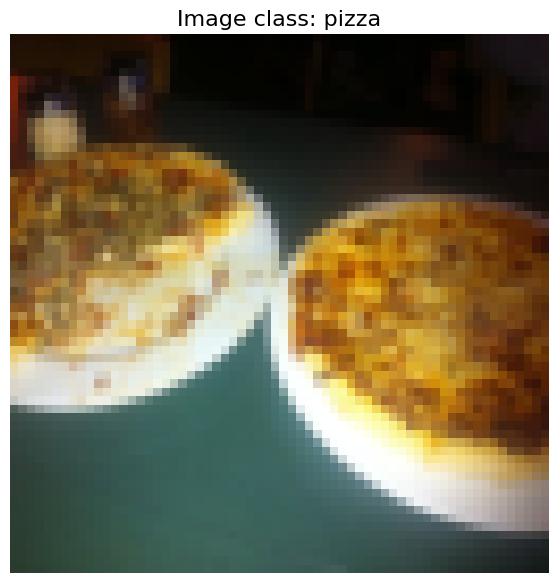

In [16]:
# Rearrange the order dimensions of the image tensor for plotting
img_permuted = img.permute(1, 2, 0)

# Print out different shapes of the image tensor
print(f"Original image shape: {img.shape} -> [color_channels, height, width]")
print(f"Permuted image shape: {img_permuted.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permuted)
plt.title(f"Image class: {class_names[label]}", fontsize=16)
plt.axis(False)

### Turn loaded images into `DataLoader`'s

`DataLoader` is a class that provides an iterable over a dataset. We can use it to load our data in batches.

In [17]:
import os

os.cpu_count()

10

In [18]:
# Turn train and test datasets into DataLoader
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 1

train_dataloader = DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)
test_dataloader = DataLoader(
    dataset=test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False
)

len(train_dataloader), len(test_dataloader)

(8, 3)

In [19]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch size, color channels, height, width]")
print(f"Label shape: {label.shape} -> [batch size]")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch size, color channels, height, width]
Label shape: torch.Size([32]) -> [batch size]


### Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

In [20]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [21]:
# Instance of torchvision.datasets.ImageFolder
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [22]:
# Helper function to get class names
# 1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format)
# 2. Raise error if the class names are not found (something wrong with the directory structure)
# 3. Turn the class names into a dict and a list and return them

# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")
class_names_found = sorted(
    [entry.name for entry in os.scandir(target_directory) if entry.is_dir()]
)
print(f"Class names found: {class_names_found}")

Target dir: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [23]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Returns the class names and their corresponding indices found in a target directory.

    Args:
            directory (str): The target directory to search for class names.

    Returns:
            Tuple[Dict[str, int], List[str]]: A tuple of the class names dictionary and a list of class names.
    """

    # Get the class names
    classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

    # Raise error if no class names found
    if not classes:
        raise FileNotFoundError(
            f"No class directories found in the target directory: {directory}"
        )

    # Create a dictionary of class names and their indices
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [24]:
find_classes(directory=train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
   * paths - paths of our images
   * transform - transform to apply to our images
   * classes - classes of our images
   * class_to_idx - dictionary mapping classes to indices
4. Create a function to `load_images()` to load images from our paths
5. Override the `__len__` and `__getitem__` functions to return the length of our dataset and a sample from our dataset respectively.

In [25]:
# Write a custom dataset class
from torch.utils.data import Dataset


# 1. Subclass the Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, targ_dir: str, transform: transforms.Compose = None):
        # 3. Create class attributes
        self.targ_dir = targ_dir
        self.transform = transform
        # All of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.classes, self.class_to_idx = find_classes(directory=targ_dir)

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        img_path = self.paths[index]
        return Image.open(img_path)

    # 5. Create a function to get the length of the dataset
    def __len__(self) -> int:
        return len(self.paths)

    # 6. Override the __getitem__ method
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        # Load the image
        img = self.load_image(index)
        class_name = self.paths[
            index
        ].parent.name  # data_folder/class_name/image_name.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            img = self.transform(img)

        return img, class_idx

In [26]:
# Create a transform
train_transform = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
    ]
)
test_transform = transforms.Compose(
    [transforms.Resize(size=(64, 64)), transforms.ToTensor()]
)

In [27]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transform)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=test_transform)

In [28]:
len(train_data), len(train_data_custom)

(225, 225)

In [29]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Function to display random images
1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to display at 10.
3. Set the random seed for reproducibility.
4. Get a list of random sample indices from the target dataset.
5. Matplotlib to display the images.
6. Loop through the images and display them.
7. Make sure the dimensions of images line up with matplotlib's expectations.

In [30]:
# 1. Function to take in a dataset
import torch.utils
import torch.utils.data


def display_random_images(
    dataset: torch.utils.data.Dataset,
    classes: List[str] = None,
    n: int = 10,
    display_shape: bool = True,
    seed: int = None,
):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False

    # 3. Set seed
    if seed:
        torch.manual_seed(seed)

    # 4. Get random indices
    random_samples_idx = torch.randperm(len(dataset))[:n]

    # 5. Loop through random indices and display images
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(random_samples_idx):
        targ_img, targ_label = dataset[idx]
        plt.subplot(1, n, i + 1)
        plt.imshow(targ_img.permute(1, 2, 0))
        plt.axis(False)
        title = ""
        if classes:
            title = f"Class: {classes[targ_label]}"
        if display_shape:
            title += f" | Shape: {targ_img.shape}"
        plt.title(title, fontsize=12)
    plt.tight_layout()

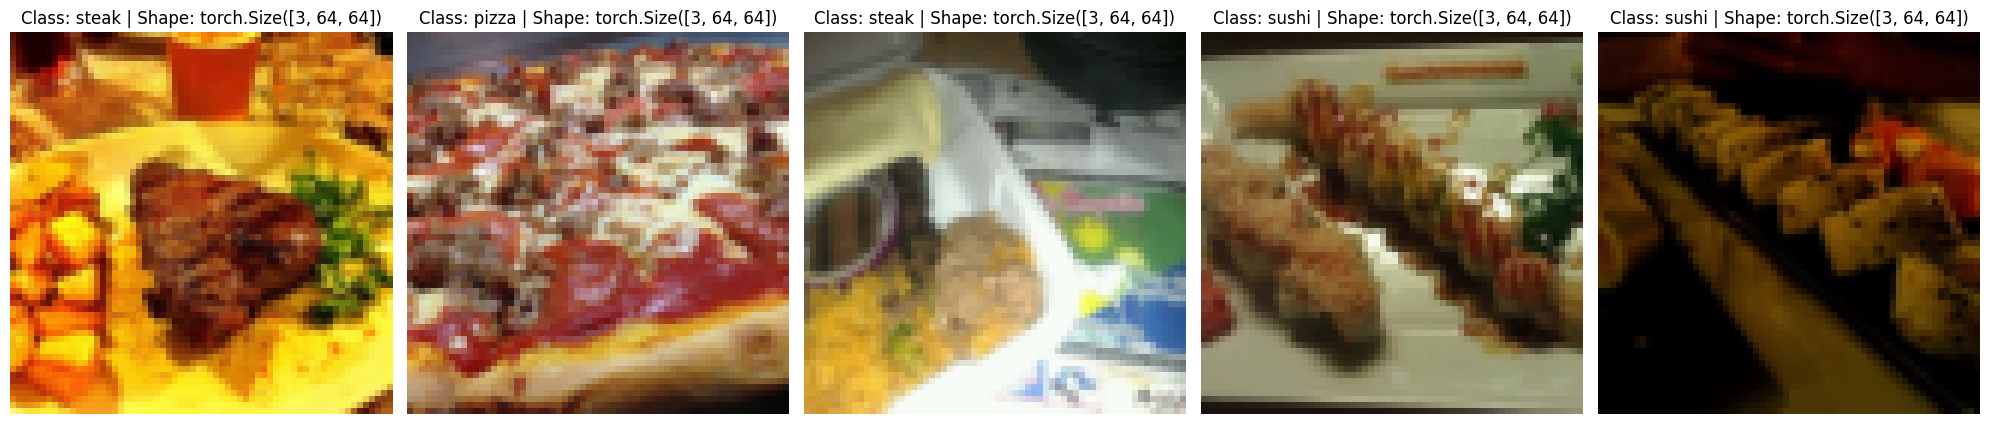

In [31]:
display_random_images(train_data, classes=class_names, n=5, seed=None)

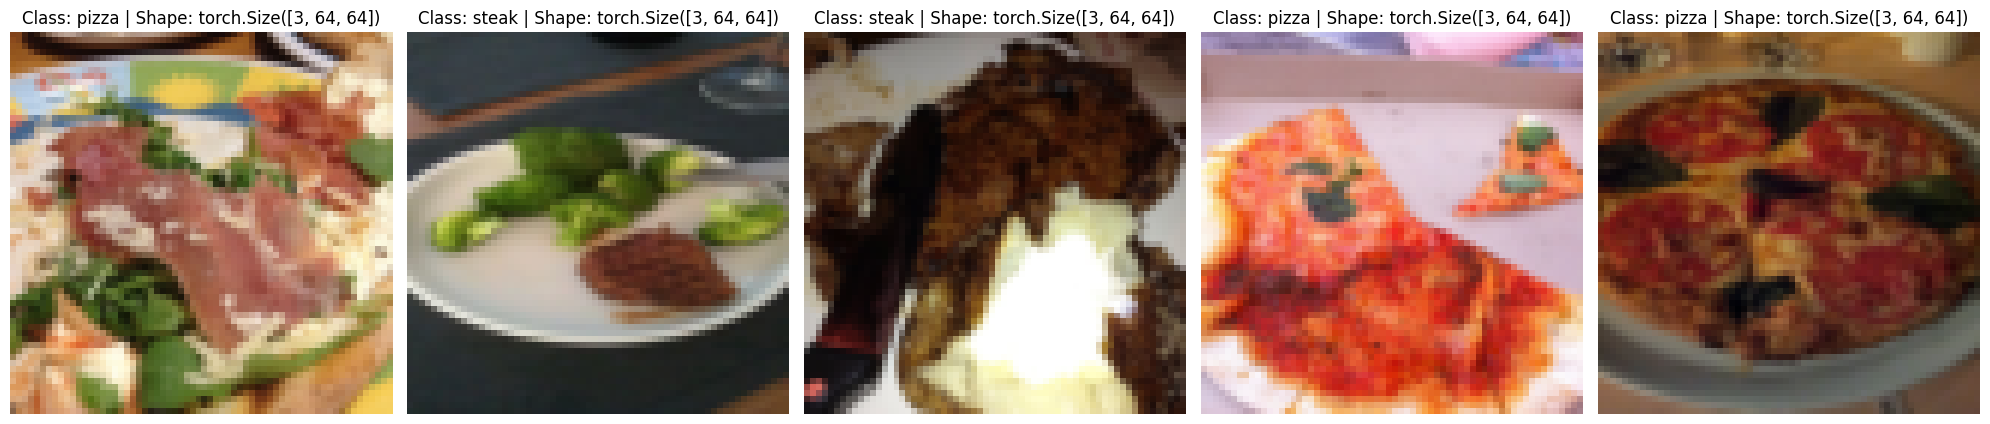

In [32]:
# Display random images from the ImageFolderCustom dataset
display_random_images(
    train_data_custom, classes=train_data_custom.classes, n=5, seed=None
)

### Turn custom loaded images into `DataLoader`'s

In [33]:
from torch.utils.data import DataLoader

train_dataloader_custom = DataLoader(
    dataset=train_data_custom,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_dataloader_custom = DataLoader(
    dataset=test_data_custom,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

len(train_dataloader_custom), len(test_dataloader_custom)

(8, 3)

In [34]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## Data Augmentation

Data augmentation is the process of artificially adding diversity to our training dataset by applying random (but realistic) transformations to our training images.

In [35]:
# Trivial augmentation
from torchvision import transforms

train_transform = transforms.Compose(
    [
        transforms.Resize(size=(224, 224)),
        transforms.TrivialAugmentWide(num_magnitude_bins=31),
        transforms.ToTensor(),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
    ]
)

In [36]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg')]

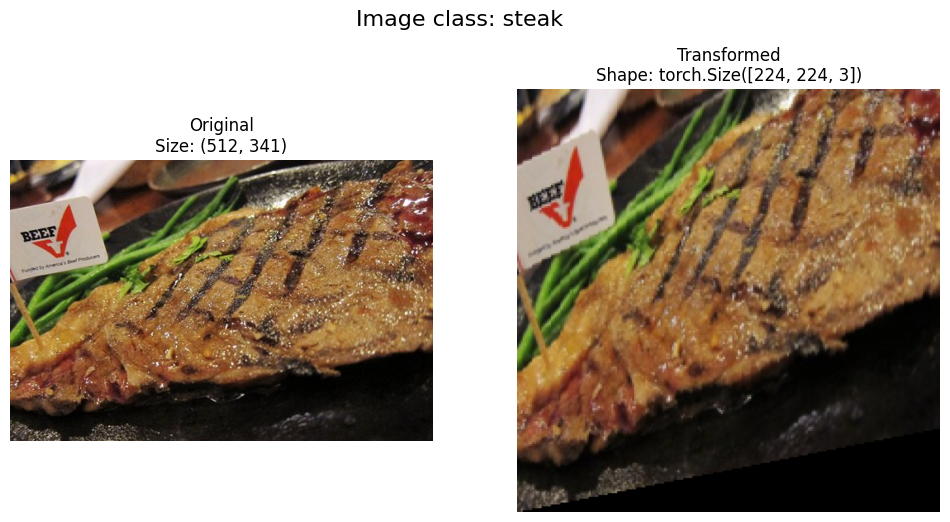

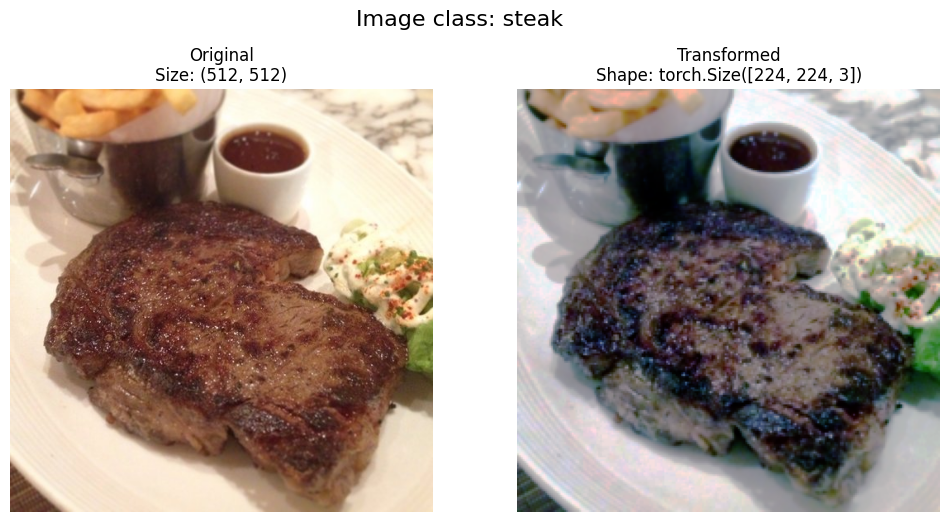

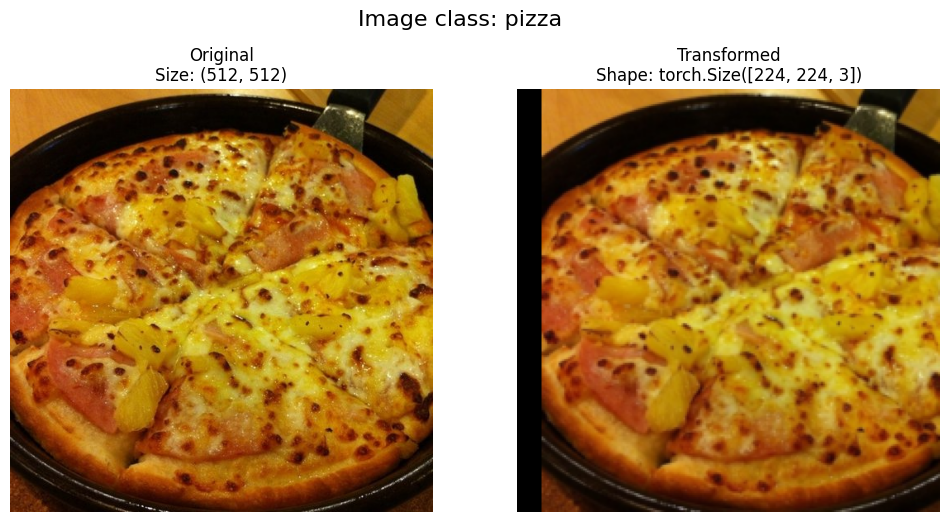

In [37]:
plot_transformed_images(img_paths=image_path_list, transform=train_transform, seed=None)

## Model 0: TinyVGG without data augmentation

### Creating transforms and loading data for Model 0

In [38]:
# Create transform
simple_transform = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor(),
    ]
)

In [39]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn the datasets into DataLoader
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoaders
train_dataloader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)
test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
)

### TinyVGG model class

In [40]:
from torch import nn


class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 13 * 13, out_features=output_shape),
        )

    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [41]:
torch.manual_seed(42)
model_0 = TinyVGG(
    input_shape=3,  # Number of color channels in the images
    hidden_units=10,  # Hidden units in the convolutional layers
    output_shape=len(class_names),  # Number of classes to output
).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [42]:
# Get a single image to test the model
img_batch, label_batch = next(iter(train_dataloader_simple))
img_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [43]:
model_0(img_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4989e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1758e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### Use `torchinfo` to inspect our model

In [44]:
from torchinfo import summary

summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## Create train and test loops functions

* `train_step()` - takes in a model and a dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and a dataloader and evaluate the model on the dataloader.

In [45]:
# Create train_step function
def train_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str = device,
) -> Tuple[float, float]:
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0.0, 0.0

    # Loop through the DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)  # output model logits

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Zero the gradients
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimize (update weights)
        optimizer.step()

        # 6. Calculate the accuracy metric
        y_pred_class = torch.argmax(
            torch.softmax(y_pred, dim=1), dim=1
        )  # softmax to convert logits to probabilities, then argmax to get the predicted class
        train_acc += torch.sum(y_pred_class == y).item() / len(y_pred)

    # Adjust the average train loss and accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [46]:
# Create test_step function
def test_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    device: str = device,
) -> Tuple[float, float]:
    # Put the model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0.0, 0.0

    # Turn on inference mode
    with torch.inference_mode():
        # Loop through the DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)  # output model logits

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # 3. Calculate the accuracy metric
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += torch.sum(test_pred_labels == y).item() / len(y)

    # Adjust the average test loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

### Create a `train()` function to combine the training and testing loops

In [47]:
from tqdm.auto import tqdm


# 1. Create a train function that takes in various model params + optimizer + loss function + dataloader
def train(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer = nn.CrossEntropyLoss(),
    epochs: int = 5,
    device: str = device,
) -> Tuple[list, list]:
    # 2. Create empty results dict
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model, train_dataloader, loss_fn, optimizer, device
        )
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
        # 4. Append results to results dict
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # 5. Print results
        print(
            f"Epoch: {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}"
        )

    # 6. Return results at the end of the epochs
    return results

/Users/macbook/.pyenv/versions/3.11.0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Train and evaluate Model 0

In [48]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Set number of epochs
EPOCHS = 5

# Initialize model
model_0 = TinyVGG(
    input_shape=3,  # Number of color channels in the images
    hidden_units=10,  # Hidden units in the convolutional layers
    output_shape=len(class_names),  # Number of classes to output
).to(device)

# Initialize loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize optimizer
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start
from timeit import default_timer as timer

start = timer()
# Train the model
results_0 = train(
    model=model_0,
    train_dataloader=train_dataloader_simple,
    test_dataloader=test_dataloader_simple,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
)
print(f"Time taken: {timer() - start:.3f} seconds")

 20%|██        | 1/5 [01:00<04:03, 60.88s/it]

Epoch: 1/5 | Train Loss: 1.1063 | Train Acc: 0.3047 | Test Loss: 1.0983 | Test Acc: 0.3011


 40%|████      | 2/5 [02:01<03:02, 60.72s/it]

Epoch: 2/5 | Train Loss: 1.0998 | Train Acc: 0.3281 | Test Loss: 1.0697 | Test Acc: 0.5417


 60%|██████    | 3/5 [03:01<02:00, 60.49s/it]

Epoch: 3/5 | Train Loss: 1.0869 | Train Acc: 0.4883 | Test Loss: 1.0807 | Test Acc: 0.4924


 80%|████████  | 4/5 [04:02<01:00, 60.53s/it]

Epoch: 4/5 | Train Loss: 1.0844 | Train Acc: 0.4023 | Test Loss: 1.0607 | Test Acc: 0.5833


100%|██████████| 5/5 [05:02<00:00, 60.57s/it]

Epoch: 5/5 | Train Loss: 1.0663 | Train Acc: 0.4141 | Test Loss: 1.0657 | Test Acc: 0.5644
Time taken: 302.874 seconds


### Plot the loss and accuracy curves of Model 0

A **loss curve** is a way to see how your model's loss (lower is better) is changing over time. A **accuracy curve** is a way to see how your model's accuracy (higher is better) is changing over time.

In [49]:
# Get the results keys
results_0.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [50]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """
    Plots training curves of a results dictionary.
    """
    # Get the loss values of the results dictionary (training and testing)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of the results dictionary (training and testing)
    acc = results["train_acc"]
    test_acc = results["test_acc"]

    # Figure out how many epochs the model was trained for
    epochs = range(len(loss))  # number of epochs

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, test_loss, label="Testing Loss")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()  # Add the legend to the plot. Legend is used to describe the elements of the graph.

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label="Training Accuracy")
    plt.plot(epochs, test_acc, label="Testing Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Show the plot
    plt.show()

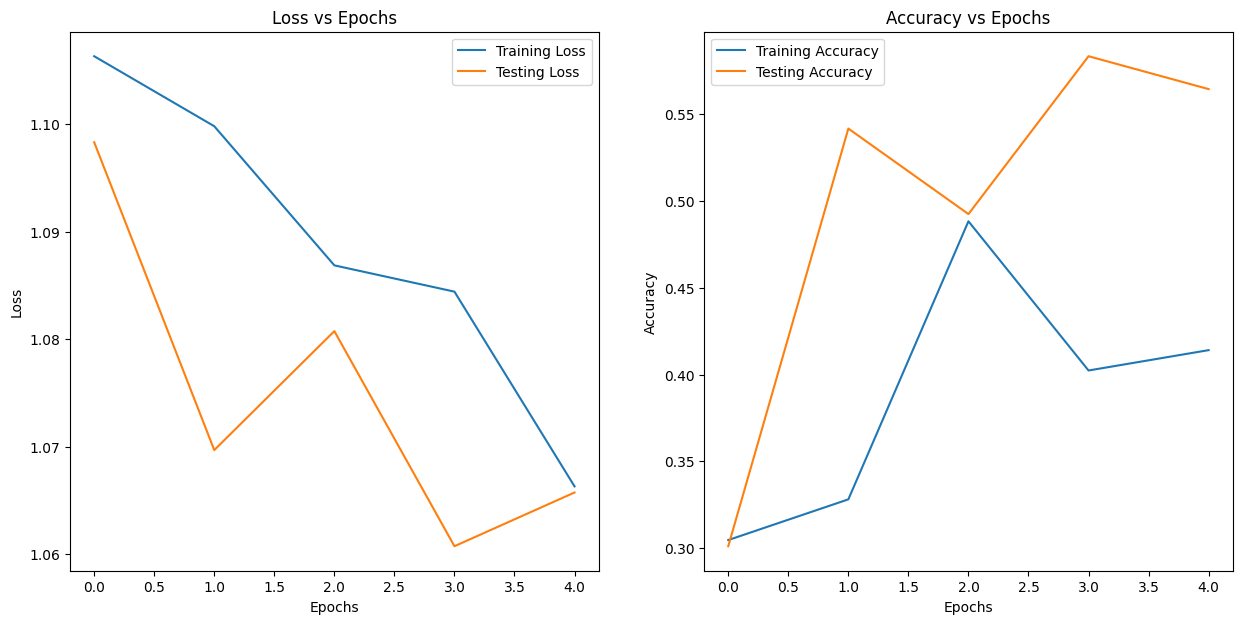

In [51]:
plot_loss_curves(results_0)

## Model 1: TinyVGG with data augmentation

### Creating transform with data augmentation

In [52]:
# Create training transform with TrivialAugment
from torchvision import transforms

train_transform_trivial = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.TrivialAugmentWide(num_magnitude_bins=31),
        transforms.ToTensor(),
    ]
)

test_transform_simple = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor(),
    ]
)

In [53]:
# Create datasets and dataloaders
from torchvision import datasets
from torch.utils.data import DataLoader

train_data_augmented = datasets.ImageFolder(
    root=train_dir, transform=train_transform_trivial
)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=test_transform_simple)

train_dataloader_trivial = DataLoader(
    dataset=train_data_augmented,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)
test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
)

### Construct and train Model 1

Same model architecture as Model 0 but with data augmentation in training data.

In [54]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Initialize model
model_1 = TinyVGG(
    input_shape=3,  # Number of color channels in the images
    hidden_units=10,  # Hidden units in the convolutional layers
    output_shape=len(train_data_augmented.classes),  # Number of classes to output
).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [55]:
# Initialize loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start
start = timer()
# Train the model
results_1 = train(
    model=model_1,
    train_dataloader=train_dataloader_trivial,
    test_dataloader=test_dataloader_simple,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
)
print(f"Time taken: {timer() - start:.3f} seconds")

 20%|██        | 1/5 [01:00<04:02, 60.50s/it]

Epoch: 1/5 | Train Loss: 1.1068 | Train Acc: 0.3047 | Test Loss: 1.0996 | Test Acc: 0.2500


 40%|████      | 2/5 [02:00<03:01, 60.36s/it]

Epoch: 2/5 | Train Loss: 1.0986 | Train Acc: 0.3086 | Test Loss: 1.0716 | Test Acc: 0.5417


 60%|██████    | 3/5 [03:01<02:00, 60.38s/it]

Epoch: 3/5 | Train Loss: 1.0894 | Train Acc: 0.4180 | Test Loss: 1.0776 | Test Acc: 0.6042


 80%|████████  | 4/5 [04:01<01:00, 60.37s/it]

Epoch: 4/5 | Train Loss: 1.0984 | Train Acc: 0.3164 | Test Loss: 1.0648 | Test Acc: 0.6042


100%|██████████| 5/5 [05:01<00:00, 60.31s/it]

Epoch: 5/5 | Train Loss: 1.0916 | Train Acc: 0.3477 | Test Loss: 1.0850 | Test Acc: 0.4223
Time taken: 301.545 seconds


### Plot the loss and accuracy curves of Model 1

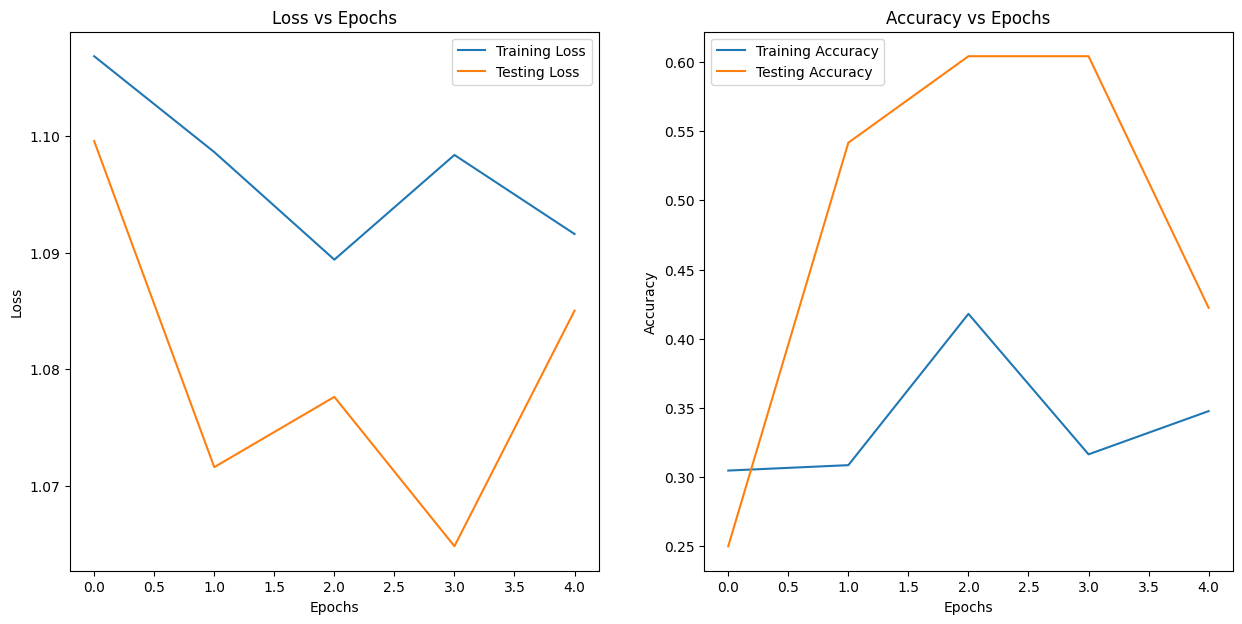

In [56]:
plot_loss_curves(results_1)

### Compare Model 0 and Model 1 results

In [57]:
import pandas as pd

model_0_df = pd.DataFrame(results_0)
model_1_df = pd.DataFrame(results_1)
model_0_df, model_1_df

(   train_loss  train_acc  test_loss  test_acc
 0    1.106319   0.304688   1.098322  0.301136
 1    1.099807   0.328125   1.069683  0.541667
 2    1.086865   0.488281   1.080749  0.492424
 3    1.084421   0.402344   1.060741  0.583333
 4    1.066306   0.414062   1.065738  0.564394,
    train_loss  train_acc  test_loss  test_acc
 0    1.106850   0.304688   1.099571  0.250000
 1    1.098629   0.308594   1.071600  0.541667
 2    1.089401   0.417969   1.077628  0.604167
 3    1.098380   0.316406   1.064818  0.604167
 4    1.091599   0.347656   1.085020  0.422348)

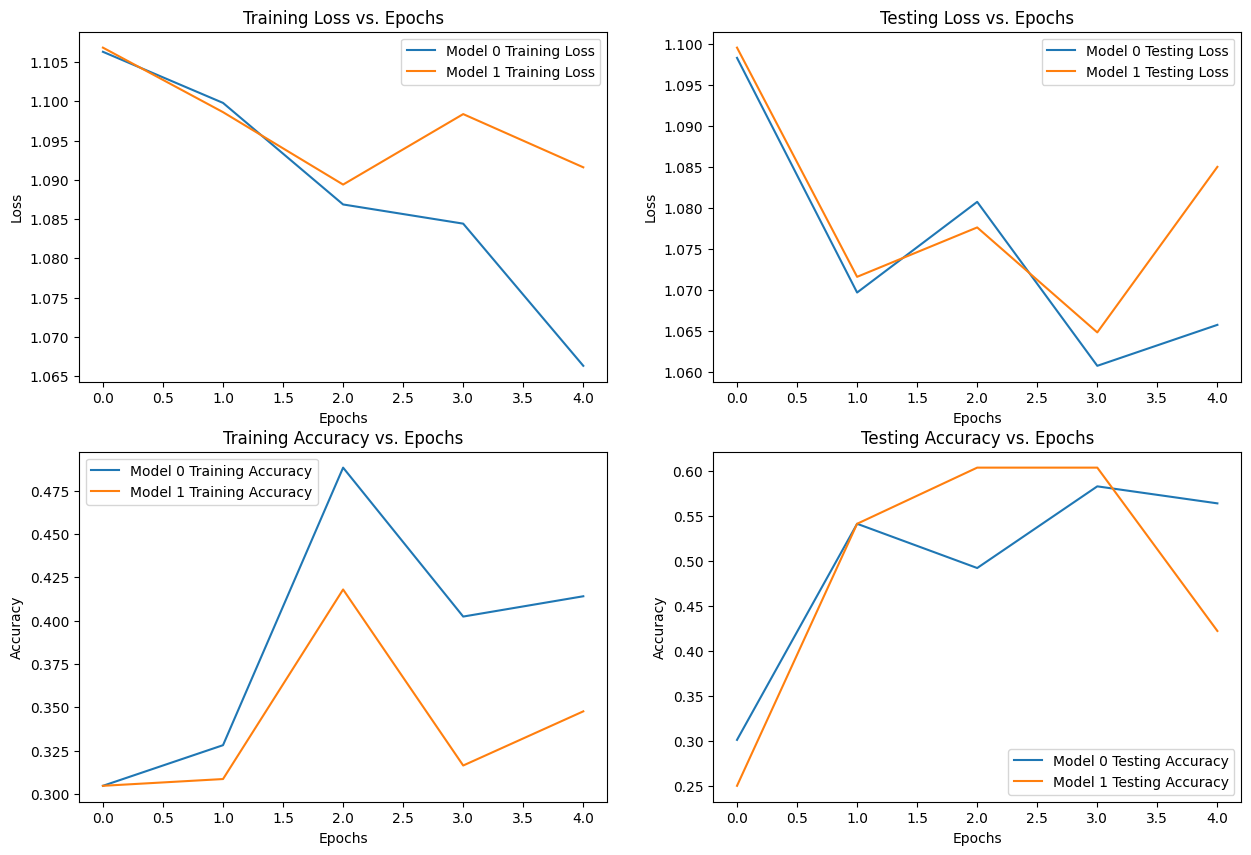

In [58]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Number of epochs
epochs = range(len(model_0_df))

# Plot the training loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0 Training Loss")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1 Training Loss")
plt.title("Training Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot the testing loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0 Testing Loss")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1 Testing Loss")
plt.title("Testing Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot the training accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0 Training Accuracy")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1 Training Accuracy")
plt.title("Training Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot the testing accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0 Testing Accuracy")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1 Testing Accuracy")
plt.title("Testing Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

## Making a prediction on a custom image

The image is not in either the training or test set.

In [61]:
# Download custom image
import requests

# Setup custom image path
custom_img_path = data_path / "04-pizza.jpeg"

# Download the custom image
if not custom_img_path.is_file():
    with open(custom_img_path, "wb") as f:
        request = requests.get(
            "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg"
        )
        f.write(request.content)
else:
    print(f"Custom image already downloaded to: {custom_img_path}")

### Loading in a custom image with PyTorch

We have to make sure custom image is in the same format as the data our model was trained on.

* In tensor with dtype float32
* Shape (64, 64, 3)
* On the same device as the model

In [63]:
import torchvision

# Read in custom image
custom_img_uint8 = torchvision.io.read_image(custom_img_path)

# Check the shape and data type of the custom image
custom_img_uint8.shape, custom_img_uint8.dtype

(torch.Size([3, 4032, 3024]), torch.uint8)

### Making a prediction on a custom image with Model 1

In [75]:
# Convert the custom image to a float tensor
custom_img = custom_img_uint8.float() / 255.0

# Check the shape and data type of the custom image
custom_img.shape, custom_img.dtype

(torch.Size([3, 4032, 3024]), torch.float32)

In [77]:
# Create transform pipeline to resize image
custom_transform = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
    ]
)

# Transform the custom image
custom_img_transformed = custom_transform(custom_img)

# Check the shape and data type of the transformed custom image
custom_img_transformed.shape, custom_img_transformed.dtype

(torch.Size([3, 64, 64]), torch.float32)

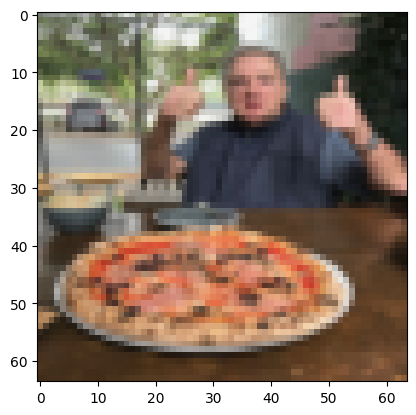

In [80]:
plt.imshow(custom_img_transformed.permute(1, 2, 0))

In [85]:
# Make a prediction on the custom image
model_1.eval()
with torch.inference_mode():
    custom_img_pred_logits = model_1(custom_img_transformed.unsqueeze(0).to(device))

# Logits -> probabilities
custom_img_pred_probs = torch.softmax(custom_img_pred_logits, dim=1)
custom_img_pred_probs

tensor([[0.3062, 0.3567, 0.3371]], device='mps:0')

In [89]:
# Probabilities -> label
custom_img_pred_label = custom_img_pred_probs.argmax(dim=1).cpu()
custom_img_pred_label

tensor([1])

In [90]:
class_names[custom_img_pred_label]

'steak'

### Putting custom image prediction together: Building a function

A function where we pass an image path to and have our model make a prediction on it.

In [94]:
def pred_and_plot_image(
    model: nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: str = device,
):
    # Load in the image, divide by 255.0 to get pixel values between 0 and 1
    target_image = torchvision.io.read_image(str(image_path)).float() / 255.0

    # Transform the image if a transform is provided
    if transform:
        target_image = transform(target_image)

    # On the target device
    model.to(device)

    # Turn on evaluation mode and make a prediction
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image tensor to simulate a batch and send it to the target device
        target_image = target_image.unsqueeze(0).to(device)

        # Make a prediction
        target_pred_logits = model(target_image)

    # Get the predicted class label
    target_pred_probs = torch.softmax(target_pred_logits, dim=1)
    target_pred_label = target_pred_probs.argmax(dim=1).cpu().item()

    # Plot the image and the prediction
    plt.imshow(target_image.cpu().squeeze().permute(1, 2, 0))
    if class_names:
        title = f"Prediction: {class_names[target_pred_label]} | Probability: {target_pred_probs.max().cpu():.2f}"
    else:
        title = f"Prediction: {target_pred_label} | Probability: {target_pred_probs.max().cpu():.2f}"
    plt.title(title)
    plt.axis(False)
    plt.show()

    return target_pred_label

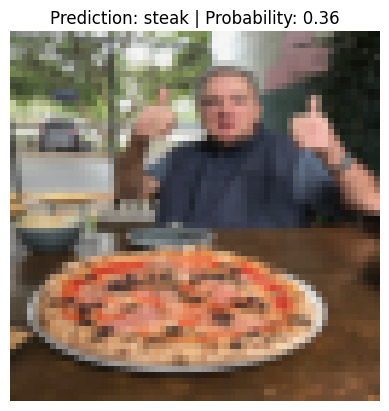

1

In [99]:
pred_and_plot_image(
    model=model_1,
    image_path=custom_img_path,
    class_names=class_names,
    transform=custom_transform,
    device=device,
)